In [81]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Analiza i priprema podataka 

In [82]:
PATH_TO_PARQUET = Path(r"C:/Users/Ki/OneDrive - fer.hr/Documents/GitHub/ML-Projekt-Vicuna/btc_historical_price.parquet")

if not PATH_TO_PARQUET.exists():
    f"Datoteka nije pronađena: {PATH_TO_PARQUET}"

df = pd.read_parquet(PATH_TO_PARQUET)
print(df.shape)
df.head()

(50676, 7)


,Date,Open,High,Low,Close,Trades,Volume
0,2020-01-01 01:00:00,7189.43,7190.52,7170.15,7171.55,3688.0,2449.049
1,2020-01-01 02:00:00,7171.43,7225.00,7171.10,7210.24,6635.0,3865.038
2,2020-01-01 03:00:00,7210.38,7239.30,7206.46,7237.99,5120.0,3228.365
3,2020-01-01 04:00:00,7237.41,7239.74,7215.00,7221.65,4143.0,2513.307
4,2020-01-01 05:00:00,7221.80,7225.41,7211.22,7213.86,1966.0,1176.666


In [83]:
df["Date"] = pd.to_datetime(df["Date"], utc=True, errors="coerce")
df = df.dropna(subset=["Date"]).sort_values("Date").set_index("Date")

In [84]:
idx = df.index
full_range = pd.date_range(start=idx.min(), end=idx.max(), freq="H")
missing = full_range.difference(idx)
duplicated = idx[idx.duplicated()]

print("Početak:", idx.min())
print("Kraj:", idx.max())
print(f"Broj nedostajućih sati: {len(missing)}")
print(f"Broj duplikata: {len(duplicated)}")

Početak: 2020-01-01 01:00:00+00:00
Kraj: 2025-10-12 12:00:00+00:00
Broj nedostajućih sati: 0
Broj duplikata: 0


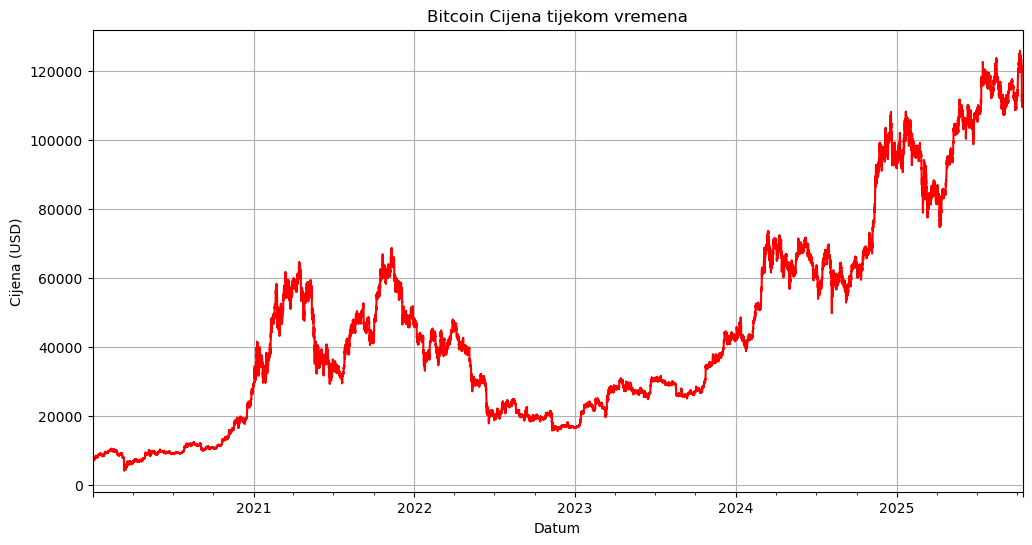

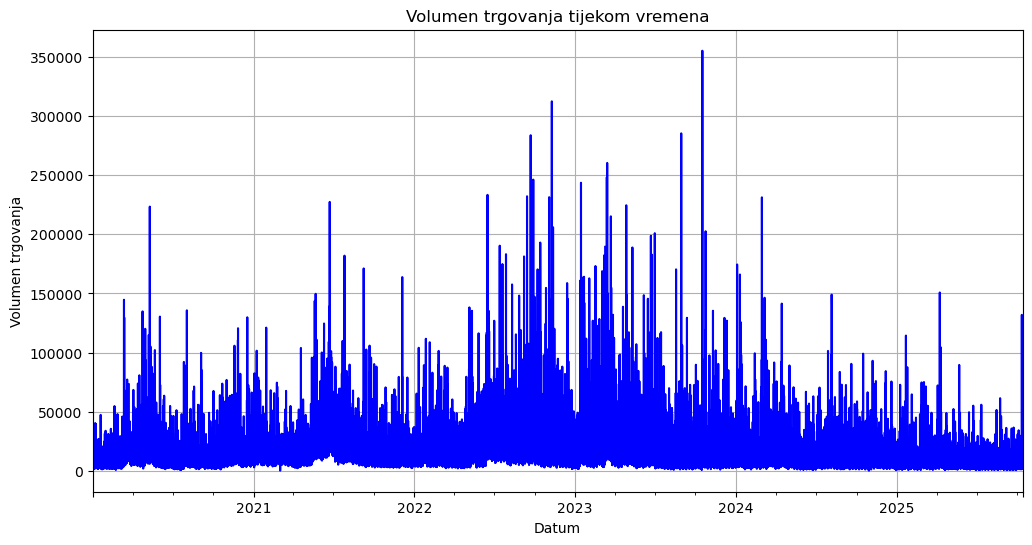

In [85]:
plt.figure(figsize=(12, 6))
df['Close'].plot(title='Bitcoin Cijena tijekom vremena', color = 'red')
plt.xlabel('Datum')
plt.ylabel('Cijena (USD)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
df['Volume'].plot(title='Volumen trgovanja tijekom vremena', color = 'blue')
plt.xlabel('Datum')
plt.ylabel('Volumen trgovanja')
plt.grid(True)
plt.show()



In [86]:
#Lagged returns
df["return_t_1"] = np.log(df["Close"] / df["Close"].shift(1))
df["return_t_5"] = np.log(df["Close"] / df["Close"].shift(5))
df["return_t_10"] = np.log(df["Close"] / df["Close"].shift(10))

In [87]:
#Volatilnost
df["volatility_5"] = df["return_t_1"].rolling(window=5*24).std()
df["volatility_10"] = df["return_t_1"].rolling(window=10*24).std()
df["volatility_20"] = df["return_t_1"].rolling(window=20*24).std()

In [88]:
#Moving averages
df["sma_5"] = df["Close"].rolling(window=5).mean()
df["sma_20"] = df["Close"].rolling(window=20).mean()
df["ema_10"] = df["Close"].ewm(span=10, adjust=False).mean()

In [89]:
#Volume indicators
df["volume_ratio_10"] = df["Volume"] / df["Volume"].rolling(window=10).mean()

In [90]:
#Price ratios
df["ratio_high_low"] = df["High"] / df["Low"]
df["ratio_close_open"] = df["Close"] / df["Open"]

In [91]:
#Momentum indicators
df["momentum"] = df["Close"] - df["Close"].shift(5)

In [92]:
#Time-based features
df["hour"] = df.index.hour
df["day_of_week"] = df.index.dayofweek
df["month"] = df.index.month

In [93]:
#Target variable: buduća stopa povrata
df["target"] = df["return_t_1"].shift(-1)

In [94]:
#Tehnički indikatori


# RSI (Relative Strength Index)
def compute_RSI(series, window=14):
    delta = series.diff(1)
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    rsi = 100 - (100 / (1 + rs))
    return rsi

df["rsi_14"] = compute_RSI(df["Close"], window=14)

# MACD (Moving Average Convergence Divergence)
ema_12 = df["Close"].ewm(span=12, adjust=False).mean()
ema_26 = df["Close"].ewm(span=26, adjust=False).mean()
df["macd"] = ema_12 - ema_26
df["macd_signal"] = df["macd"].ewm(span=9, adjust=False).mean()

# Bollinger Bands
window = 20
rolling_mean = df["Close"].rolling(window).mean()
rolling_std = df["Close"].rolling(window).std()
df["bb_high"] = rolling_mean + (2 * rolling_std)
df["bb_low"] = rolling_mean - (2 * rolling_std)

In [95]:
df = df.dropna().copy()

print("✅ Broj značajki:", len(df.columns))
df.head(10)

✅ Broj značajki: 28


,Open,High,Low,Close,Trades,Volume,return_t_1,return_t_5,return_t_10,volatility_5,...,momentum,hour,day_of_week,month,target,rsi_14,macd,macd_signal,bb_high,bb_low
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-21 01:00:00+00:00,8650.00,8668.00,8621.27,8651.82,9321.0,5706.821,0.000210,-0.003062,-0.001789,0.005518,...,-26.53,1,1,1,0.001117,48.598067,-17.350279,-24.624028,8712.514747,8607.234253
2020-01-21 02:00:00+00:00,8650.90,8669.79,8642.36,8661.49,3864.0,2273.105,0.001117,-0.002134,-0.002154,0.005431,...,-18.50,2,1,1,0.001097,57.334848,-16.228559,-22.944934,8710.736693,8607.156307
2020-01-21 03:00:00+00:00,8661.55,8682.92,8653.37,8671.00,3759.0,2327.215,0.001097,-0.003233,-0.000545,0.005429,...,-28.08,3,1,1,0.000922,66.680476,-14.406146,-21.237177,8708.670130,8607.670870
2020-01-21 04:00:00+00:00,8671.00,8688.00,8664.00,8679.00,3161.0,1959.806,0.000922,0.002126,0.003483,0.005429,...,18.43,4,1,1,-0.000357,64.549542,-12.175980,-19.424937,8709.905837,8607.535163
2020-01-21 05:00:00+00:00,8679.00,8700.00,8673.70,8675.90,4268.0,2314.001,-0.000357,0.002990,0.000573,0.005427,...,25.90,5,1,1,-0.001258,52.445204,-10.537235,-17.647397,8711.590522,8608.632478
2020-01-21 06:00:00+00:00,8675.80,8685.00,8647.90,8664.99,4320.0,2589.035,-0.001258,0.001521,-0.001541,0.005402,...,13.17,6,1,1,-0.001089,45.630397,-10.003549,-16.118627,8711.526562,8608.607438
2020-01-21 07:00:00+00:00,8664.99,8674.39,8645.37,8655.56,4103.0,2432.655,-0.001089,-0.000685,-0.002818,0.005399,...,-5.93,7,1,1,-0.001804,44.356148,-10.223668,-14.939635,8711.344072,8608.345928
2020-01-21 08:00:00+00:00,8655.57,8662.15,8630.00,8639.96,4248.0,2488.390,-0.001804,-0.003586,-0.006819,0.005385,...,-31.04,8,1,1,0.002662,47.353328,-11.524062,-14.256521,8710.126941,8611.285059
2020-01-21 09:00:00+00:00,8639.96,8672.00,8619.17,8662.99,7221.0,4961.221,0.002662,-0.001846,0.000279,0.005391,...,-16.01,9,1,1,-0.002943,47.641117,-10.574410,-13.520099,8701.069197,8627.594803


# 2. Modeliranje i evaluacija

In [96]:
split_index = int(len(df) * 0.8)
train = df.iloc[:split_index]
test = df.iloc[split_index:]

x_train = train.drop(columns=["target"])
y_train = train["target"]
x_test = test.drop(columns=["target"])
y_test = test["target"]

print("Train:", x_train.shape, "Test:", x_test.shape)


Train: (5406, 27) Test: (1352, 27)


In [97]:
model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R2 ): {r2:.6f}")


Mean Squared Error (MSE): 0.000022
Mean Absolute Error (MAE): 0.003171
R-squared (R2 ): -0.031018


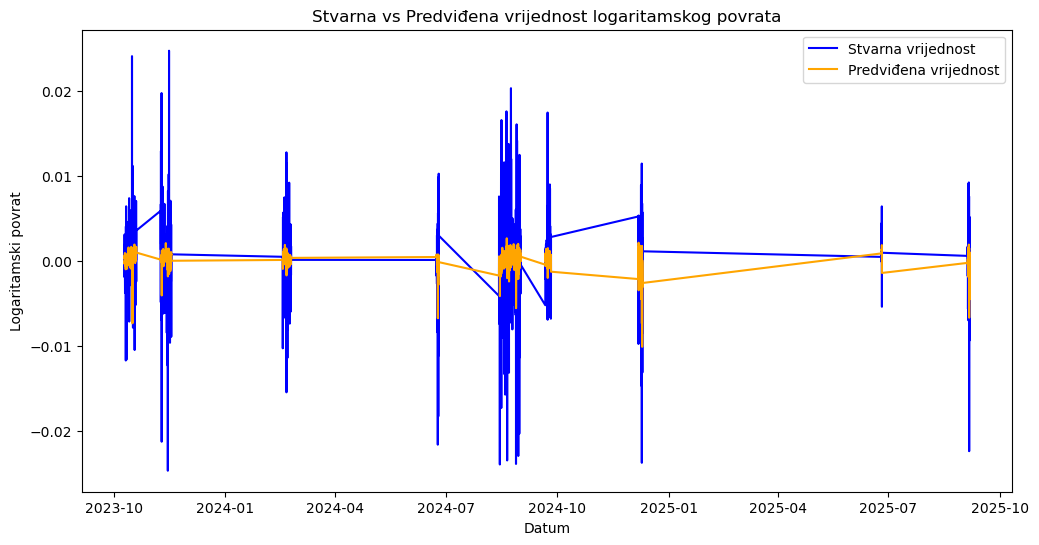

In [98]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Stvarna vrijednost', color='blue')
plt.plot(y_test.index, y_pred, label='Predviđena vrijednost', color='orange')
plt.xlabel('Datum')
plt.ylabel('Logaritamski povrat')
plt.title('Stvarna vs Predviđena vrijednost logaritamskog povrata')
plt.legend()
plt.show()
